## Sentimental Analysis

Sentiment analysis (opinion mining) refers to the use of Natural Language Processing, text analysis and computational linguistics to identify and extract subjective information from the source materials. Generally speaking, sentiment analysis aims to determine the attitude of a writer or a speaker with respeact to a specific topic or the overall contextual polarity of a document. 

Globally, business enterprises can leverage opinion polarity and sentiment topic recognition to gain deeper understanding of the drivers and the overall scope. Subsequently, these insights can advance competitive intelligence and improve customer service, thereby creating a better brand image and providing a competitive edge. 

In [76]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
tweets = pd.read_csv("Tweets.csv")

In [3]:
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [7]:
# Split complete dataframe into pos, neg and neu dataframes
filters = [tweets['airline_sentiment'] == x for x in ['positive', 'negative', 'neutral']]

pos, neg, neu = (tweets[f] for f in filters)

for df in pos, neg, neu:
    print(df.shape)

(2363, 15)
(9178, 15)
(3099, 15)


### Task 1 
#### Worst and Best airlines based on numbers of positive and negative tweets

In [8]:
#Worst airlines
worst = neg['airline'].value_counts()
worst

United            2633
US Airways        2263
American          1960
Southwest         1186
Delta              955
Virgin America     181
Name: airline, dtype: int64

In [9]:
#Best airlines
best = pos['airline'].value_counts()
best

Southwest         570
Delta             544
United            492
American          336
US Airways        269
Virgin America    152
Name: airline, dtype: int64

However, this is not the best way to decide the best or worst airlines. 

### Task 2
#### Get a list of top complaints

In [11]:
# top complaints
# Since we have negative reason, we can just run aggregation
top_complaints = neg['negativereason'].value_counts()
top_complaints

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

### Task 3
#### Plot distribution of sentiment of different airlines. Given an airline, we would like to know the number of positive / negative / neutral review. 

In [44]:
def plot_sub_sentiment(airline: str)-> None:
    '''
    Plot a bar chart for the number of pos, neg and neu tweets of given airline
    '''
    
    # Get sentiment count from airline
    df = tweets[tweets['airline'] == airline]
    count = df['airline_sentiment'].value_counts()
    
    # Plot bar
    plt.bar(count.index, count)
    
    # Add labels
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiment of ' + airline)

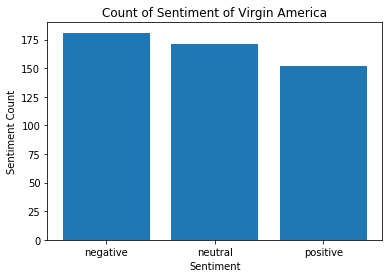

In [45]:
plot_sub_sentiment('Virgin America')

In [41]:
import math

def plot_airlines(airlines, plot_func, ncols=3) -> None:
    '''
    Plot all bar chart of all airlines in a single figure using plot_func
    '''
    # Contruct plot and subplot
    plt.figure(figsize = (16, 12))
    nrows = math.ceil(len(airlines) / ncols)
    
    for i, airline in enumerate(airlines):
        plt.subplot(nrows, ncols, i+1)
        plot_func(airline)
        
    plt.tight_layout()

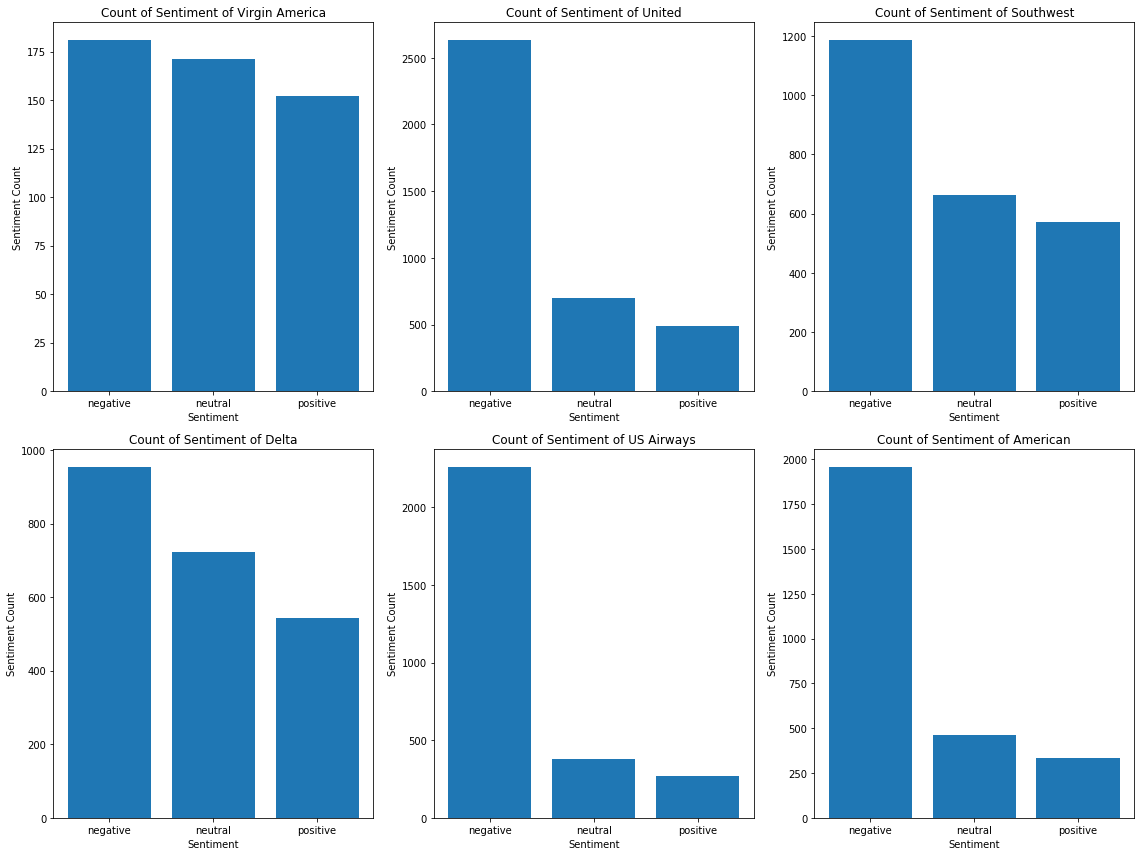

In [43]:
plot_airlines(tweets['airline'].unique(), plot_func=plot_sub_sentiment)

### Task 4
#### Plot Complaint distributions for each airlines

In [51]:
def plot_sub_neg_reason(airline: str) -> None:
    '''
    Plot a bar chart for the number each negative reasons of a given airline
    '''
    df = tweets[tweets['airline'] == airline]
    count = df['negativereason'].value_counts()
    
    plt.bar(count.index, count)
    
    plt.ylabel('Count')
    plt.xticks(count.index, rotation = 90)
    plt.xlabel('Reason')
    plt.title('Count of Negative reasons of ' + airline)

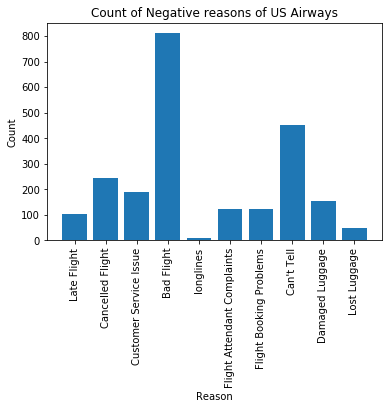

In [52]:
plot_sub_neg_reason('US Airways')

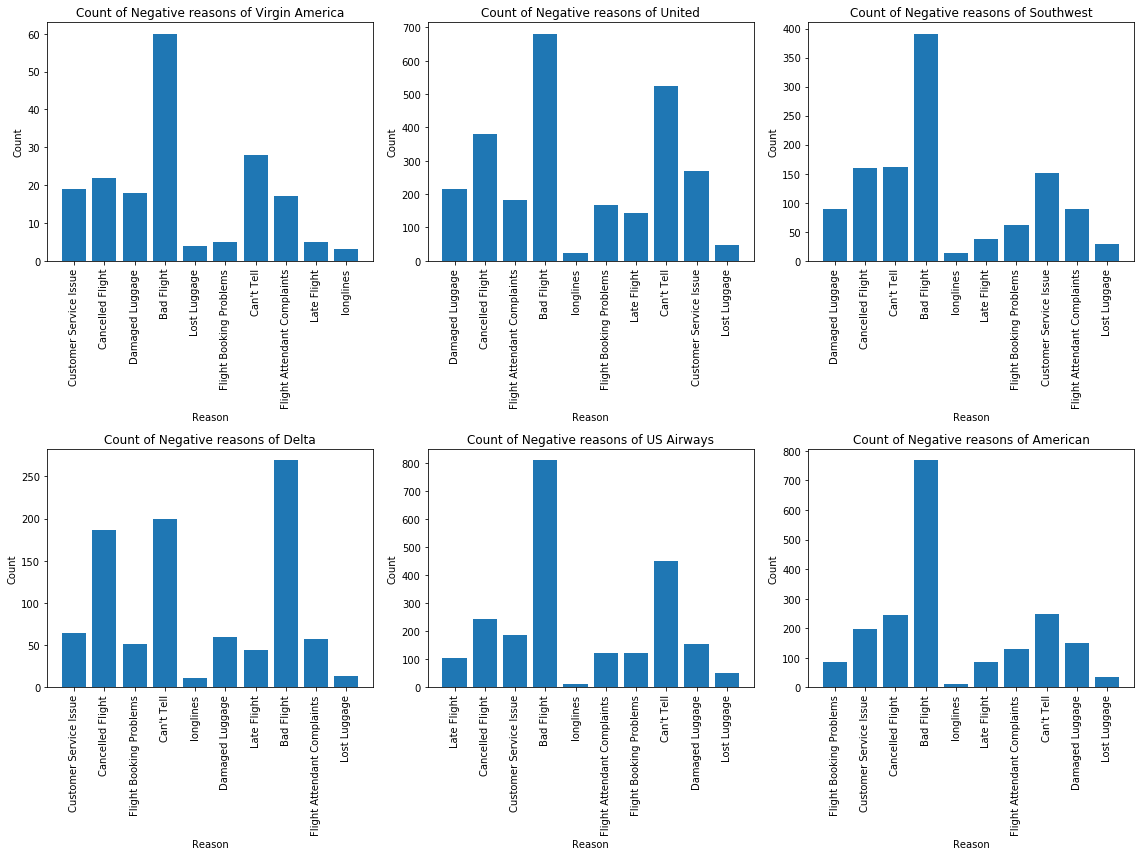

In [54]:
plot_airlines(tweets['airline'].unique(), plot_func = plot_sub_neg_reason)

### Sentiment Analysis with SVM (Binary)

In [56]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

### Task 5

1. We only take negative and positive data for training
2. For quality control, we only take reviews with high sentiment confidence

In [57]:
train = tweets.copy()

In [58]:
Conf_thold = 0.65

train = train[train['airline_sentiment'].isin(['positive', 'negative'])]
train = train[train['airline_sentiment_confidence'] > 0.65]

In [59]:
# An example of text with escapting html string
sample_text = '@VirginAmerica I &lt;3 pretty graphics &amp; nice views #niceflight'

In [60]:
import html

html.unescape(sample_text)

'@VirginAmerica I <3 pretty graphics & nice views #niceflight'

In [61]:
# Append a new column for label (1 for neg and 0 for pos)
train['sentiment'] = train['airline_sentiment'].apply(lambda x: 1 if x == 'negative' else 0)
train.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment
3367,568493225788510209,negative,1.00,Can't Tell,0.6561,United,NaN,marinwino,NaN,0,@united 777 from SFO to HNL with ZERO entertai...,NaN,2015-02-19 11:32:01 -0800,NaN,NaN,1
7344,569658903044218880,negative,1.00,Late Flight,0.6739,Delta,NaN,aaronkinnari,NaN,0,@JetBlue that is a stock response. Delays not ...,NaN,2015-02-22 16:44:00 -0800,Gotham,Quito,1
11512,568061166871846912,negative,0.68,Can't Tell,0.3500,US Airways,NaN,sternjoe92,NaN,0,@USAirways has an SPF record error that is cau...,NaN,2015-02-18 06:55:10 -0800,NaN,NaN,1
9250,570023318251642883,negative,1.00,Customer Service Issue,1.0000,US Airways,NaN,Wheres_Papi,NaN,0,@USAirways I lost an ID on your plane and havi...,NaN,2015-02-23 16:52:04 -0800,USA,Eastern Time (US & Canada),1
10966,568748360599019520,negative,1.00,Late Flight,1.0000,US Airways,NaN,jofro3,NaN,0,@USAirways thanks for taking my flight off the...,NaN,2015-02-20 04:25:50 -0800,NaN,Eastern Time (US & Canada),1


In [62]:
train['sentiment'].value_counts()

1    8787
0    2164
Name: sentiment, dtype: int64

In [63]:
X = list(train['text'])
y = list(train['sentiment'])

print('# training X: ', len(X))
print('# training y: ', len(y))

# training X:  10951
# training y:  10951


### Task 6

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   random_state = 25,
                                                   stratify = y #keep pos neg ratio
                                                   )

In [66]:
print('# of training:', len(X_train))
print('# of testing: ', len(X_test))

# of training: 8760
# of testing:  2191


### Task 7
#### Convert text into features (featurization / vectorization)

In [68]:
## Step 1. Tokenization
tw_tokenizer = TweetTokenizer()
tokens = tw_tokenizer.tokenize(sample_text)
tokens

['@VirginAmerica',
 'I',
 '<3',
 'pretty',
 'graphics',
 '&',
 'nice',
 'views',
 '#niceflight']

In [70]:
## Normalization

wn_lemmatizer = WordNetLemmatizer()
wn_lemmatizer.lemmatize('dogs')

'dog'

In [71]:
## depends on tokenizer and lemmatizer we just created
def tokenize(s: str) -> list:
    tokens = tw_tokenizer.tokenize(s)
    return [wn_lemmatizer.lemmatize(t) for t in tokens]

In [72]:
tokenize(sample_text)

['@VirginAmerica',
 'I',
 '<3',
 'pretty',
 'graphic',
 '&',
 'nice',
 'view',
 '#niceflight']

In [73]:
# Stop words Removal

en_stopwords = stopwords.words("english")
en_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [74]:
cnt_vec = CountVectorizer(
    analyzer = 'word',     # default, word level vectorization
    tokenizer = tokenize,  # override tokenization method
    ngram_range = (1, 1),  # using bag-of-word strategt
    stop_words = 'english' #remove english stopwords
)

In [75]:
#an example of vectorizer

sample_vec = cnt_vec.fit_transform(['I like football', 'I hate basketball'])
print('vocabulary:', cnt_vec.get_feature_names())
sample_vec.toarray()

vocabulary: ['basketball', 'football', 'hate', 'like']


array([[0, 1, 0, 1],
       [1, 0, 1, 0]], dtype=int64)

### Task 8
#### Build a pipeline

In [79]:
np.random.seed(1)

kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25)

# Linear SVM classifier
svc = LinearSVC(
    class_weight = 'balanced' # adjust parameter C based on pos/neg distribution
)

# Build model pipeline, all data will go through this pipeline
pipeline_svc = make_pipeline(cnt_vec, svc)

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [126]:
# Grid Search to find best parameter C for svm
grid_svm = GridSearchCV(
    estimator = pipeline_svc,
    param_grid = {'linearsvc__C': [0.01, 0.1, 1]},
    cv = kfolds,
    scoring = "f1", 
    verbose = 1,
    n_jobs = -1,  # doing grid search in parallel, -1 means using all kernels
)

In [127]:
# Check list of params
pipeline_svc.get_params()

{'countvectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words='english',
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=<function tokenize at 0x10fbe2a60>, vocabulary=None),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': 'english',
 'countvectorizer__strip_accents': None,
 'countvectorizer__token

In [128]:
grid_search = grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.3s finished


In [129]:
best_score = grid_search.best_score_
print(best_score)

0.9497608254659202


In [130]:
best_parameter = grid_search.best_params_
print(best_parameter)

{'linearsvc__C': 0.1}


### Testing

In [131]:
pred_train = grid_svm.predict(X_train)
pred_test = grid_svm.predict(X_test)

In [132]:
# Report for training data
print(classification_report(y_true = y_train, y_pred = pred_train))

             precision    recall  f1-score   support

          0       0.92      0.99      0.95      1731
          1       1.00      0.98      0.99      7029

avg / total       0.98      0.98      0.98      8760



In [133]:
# Report for testing data
print(classification_report(y_true = y_test, y_pred = pred_test))

             precision    recall  f1-score   support

          0       0.81      0.86      0.84       433
          1       0.97      0.95      0.96      1758

avg / total       0.94      0.93      0.93      2191



In [134]:
# Good Sentiment example
grid_svm.predict(['flying with @united is always a great expereince'])

array([0])

In [135]:
# Bad Sentiment example
grid_svm.predict(['@United sucks!!'])

array([1])

In [136]:
# Another bad sentiment example
grid_svm.predict(['I got very bad experience from flying with @United'])

array([1])

In [137]:
# Another bad sentiment example
grid_svm.predict(['@United treats their customers like shit'])

array([1])